In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from skimage.transform import resize

from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [2]:
qasm_sim = Aer.get_backend('qasm_simulator')
qinst = QuantumInstance(qasm_sim, 2048)

# Dataset

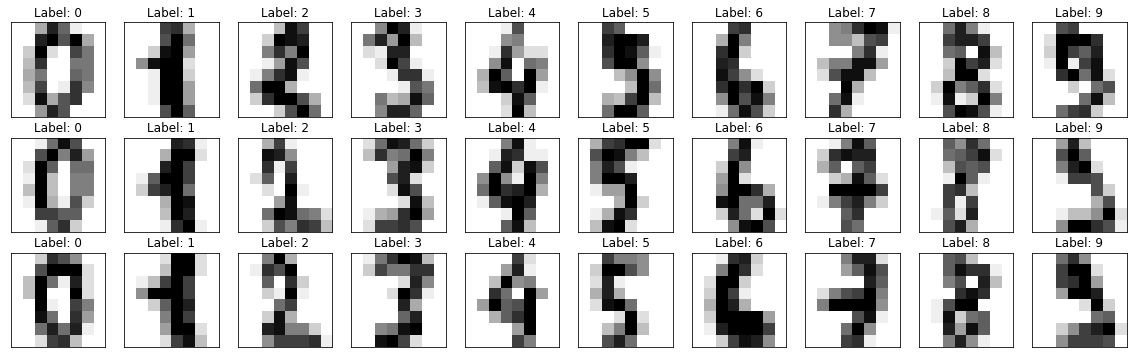

In [3]:
def show_images(data, targets):
    fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 6))
    for i in range(3):
        for l in range(10):
            axes[i, l].imshow(data[targets==l][i,:,:], cmap=plt.cm.gray_r)
            axes[i, l].set_xticks([])
            axes[i, l].set_yticks([])
            axes[i, l].set_title(f"Label: {targets[targets==l][i]}")

mnist = datasets.load_digits()
show_images(mnist.images, mnist.target)


In [4]:
def prepare_dataset(labels, num_instances, test_ratio, seed):
    mnist = datasets.load_digits()
    num_classes = len(labels)

    # Filter digits and targets
    x = mnist.images[[t in labels for t in mnist.target]]
    y = mnist.target[[t in labels for t in mnist.target]]

    # We keep only `num_instances` images for each label
    x = np.concatenate([x[y == labels[lbl]][:num_instances] for lbl in labels], axis=0)
    y = np.concatenate([y[y == labels[lbl]][:num_instances] for lbl in labels], axis=0)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=seed, stratify=y)

    return x_train, x_test, y_train, y_test

def image_resize(x, size):
    # https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
    return np.vstack([[resize(x_i, (size, 1), anti_aliasing=False) for x_i in x]])


In [5]:
labels = [0, 1]
num_instances = 50
test_ratio = 0.2
seed = 3897

x_train_8x8, x_test_8x8, y_train, y_test = prepare_dataset(labels, num_instances, test_ratio, seed)

In [6]:
feature_dim = 8
x_train_4x1 = image_resize(x_train_8x8, feature_dim) #shrinks images from 8x8 for 4x1
x_test_4x1 = image_resize(x_test_8x8, feature_dim)

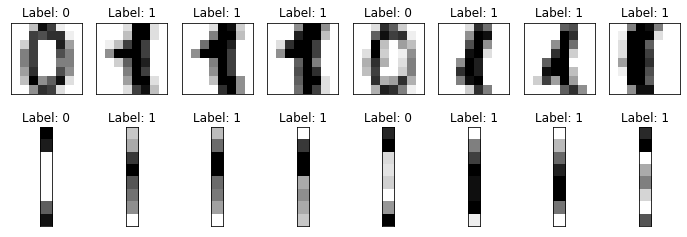

In [7]:
num_samples = 8
sources = [x_train_8x8, x_train_4x1]
fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(12, 4))
for i in range(num_samples):
    for s in range(len(sources)):
        axes[s, i].imshow(sources[s][i,:,:], cmap=plt.cm.gray_r)
        axes[s, i ].set_xticks([])
        axes[s, i].set_yticks([])
        axes[s, i].set_title(f"Label: {y_train[i]}")

# Data embedding circuits

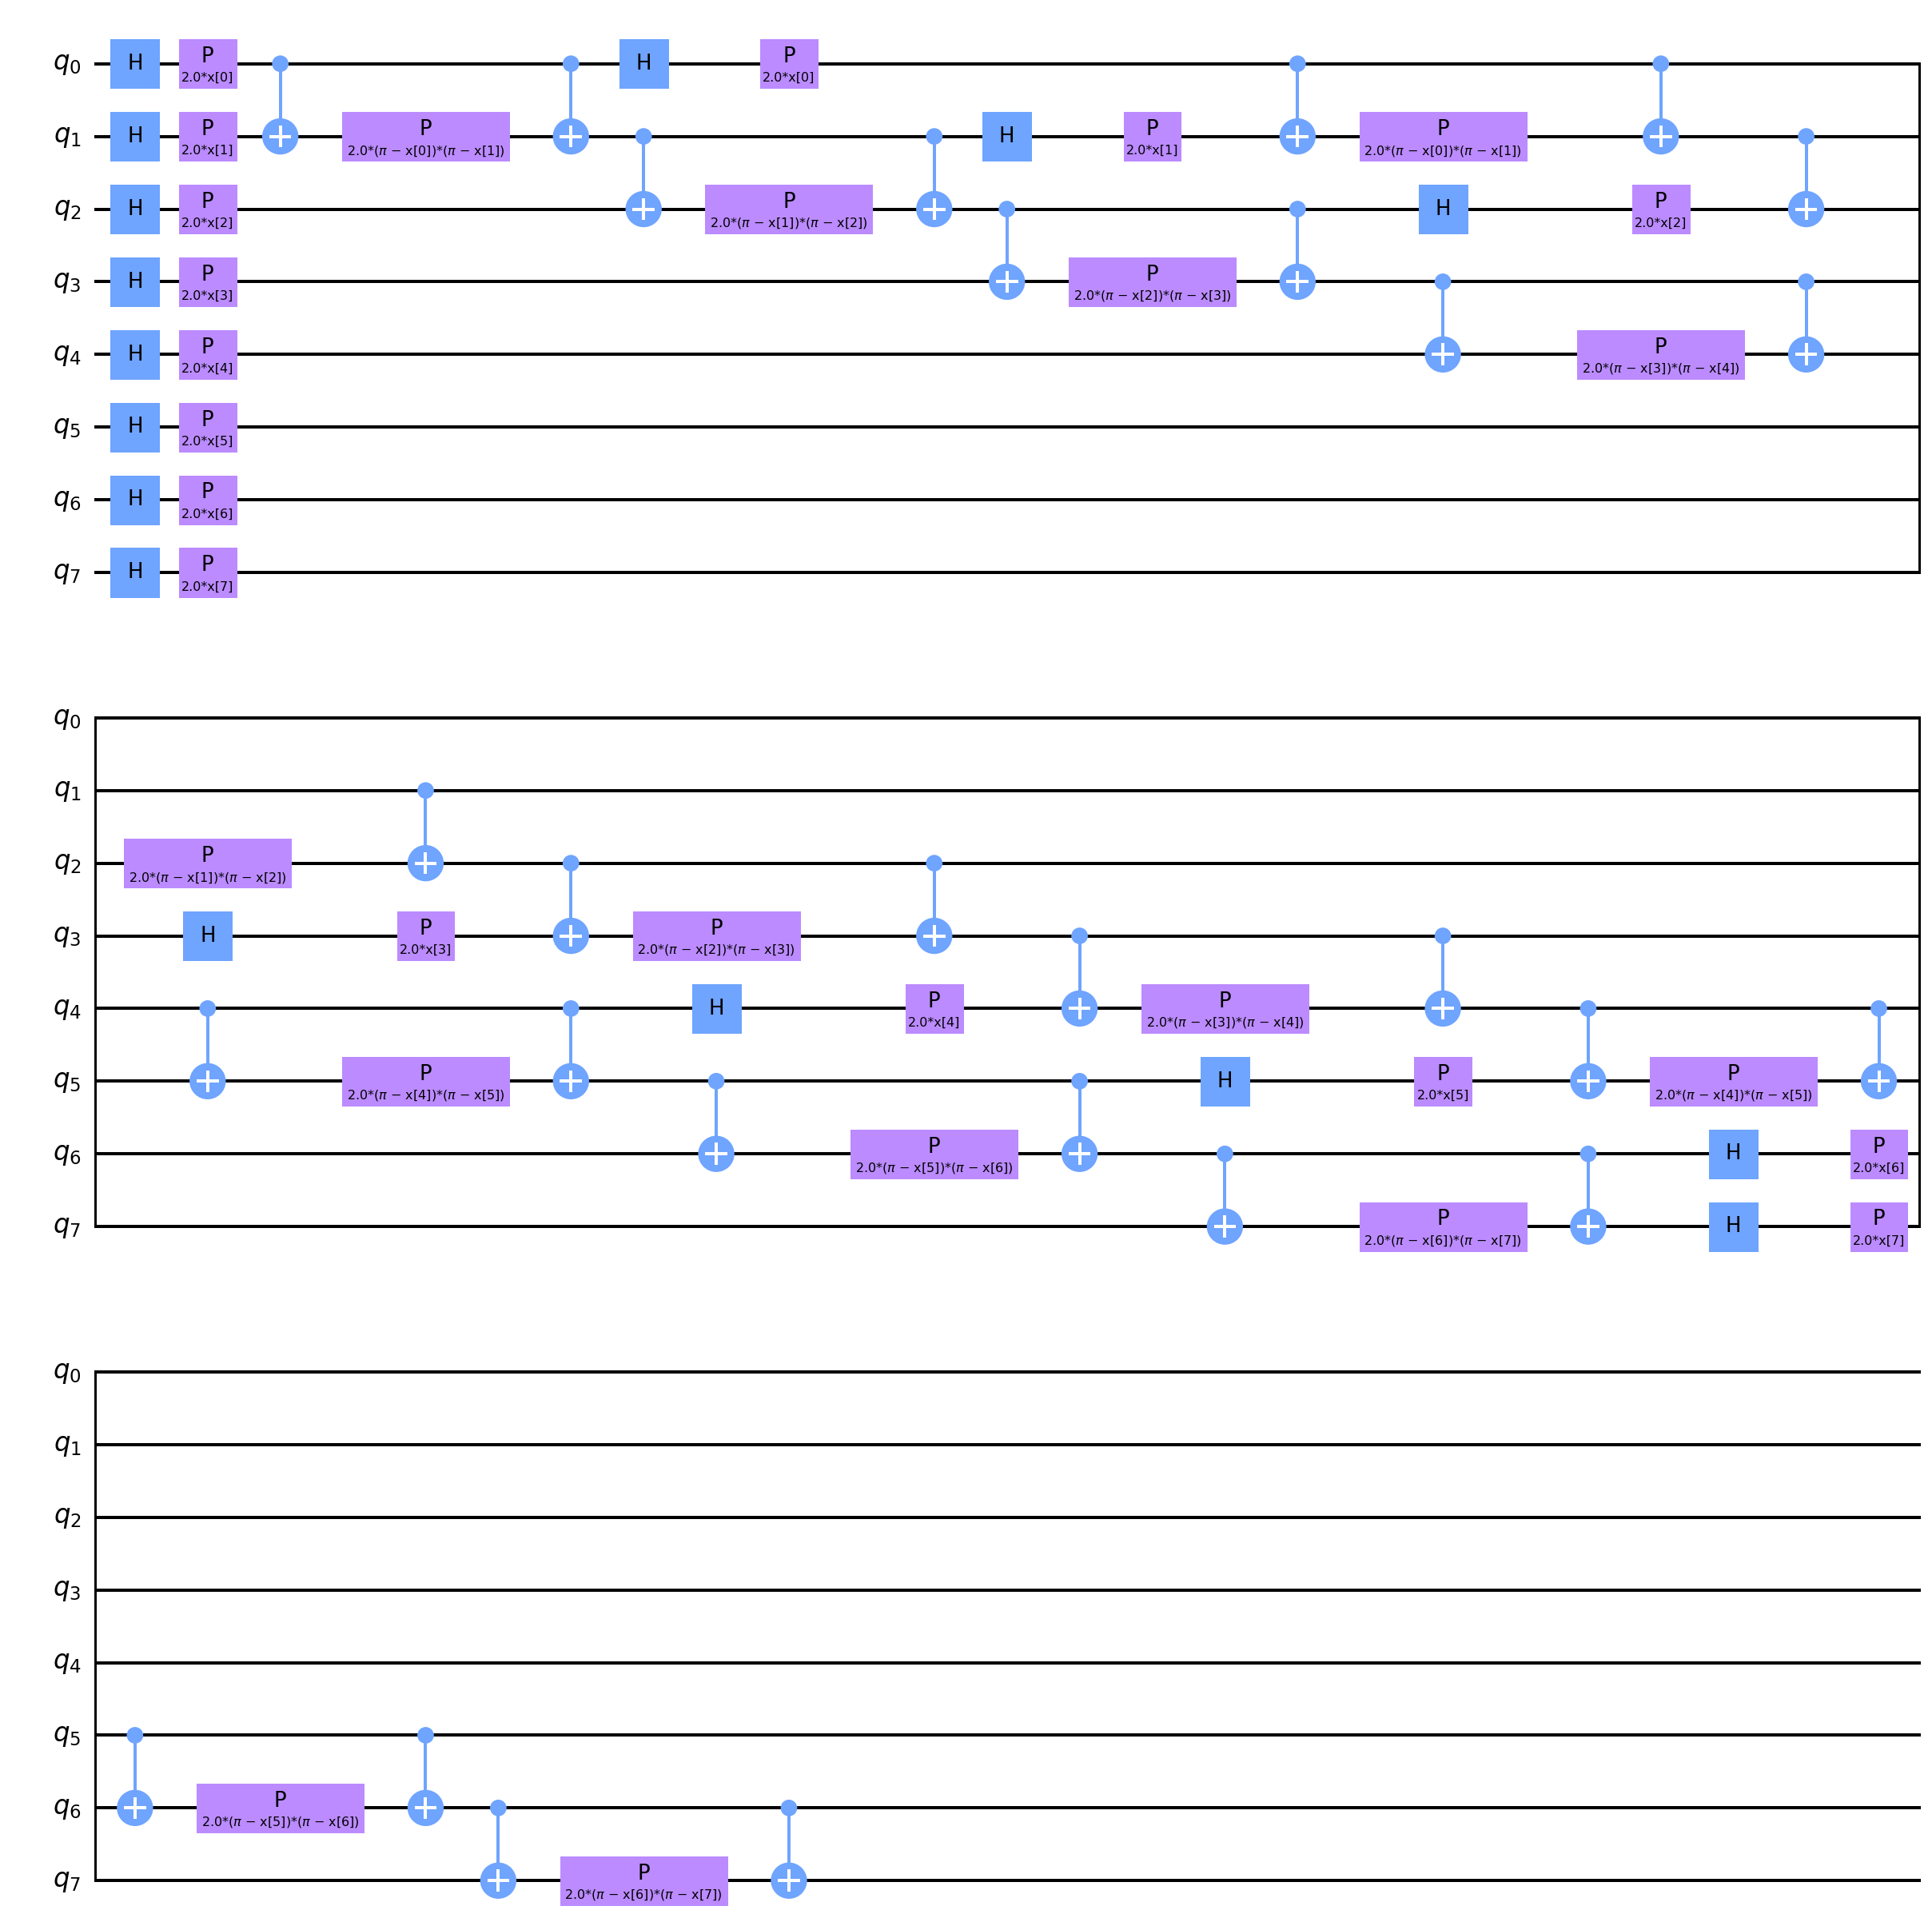

In [8]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent): 
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(feature_dim, 2, 'linear') # feature dimensions, 2 repetitions, linear entanglement
                                                       #feature_map_rep and ent are examples of hyper parameters.
                                                       # ent can be linear or full.
fmap_zz.decompose().draw('mpl', scale=2)

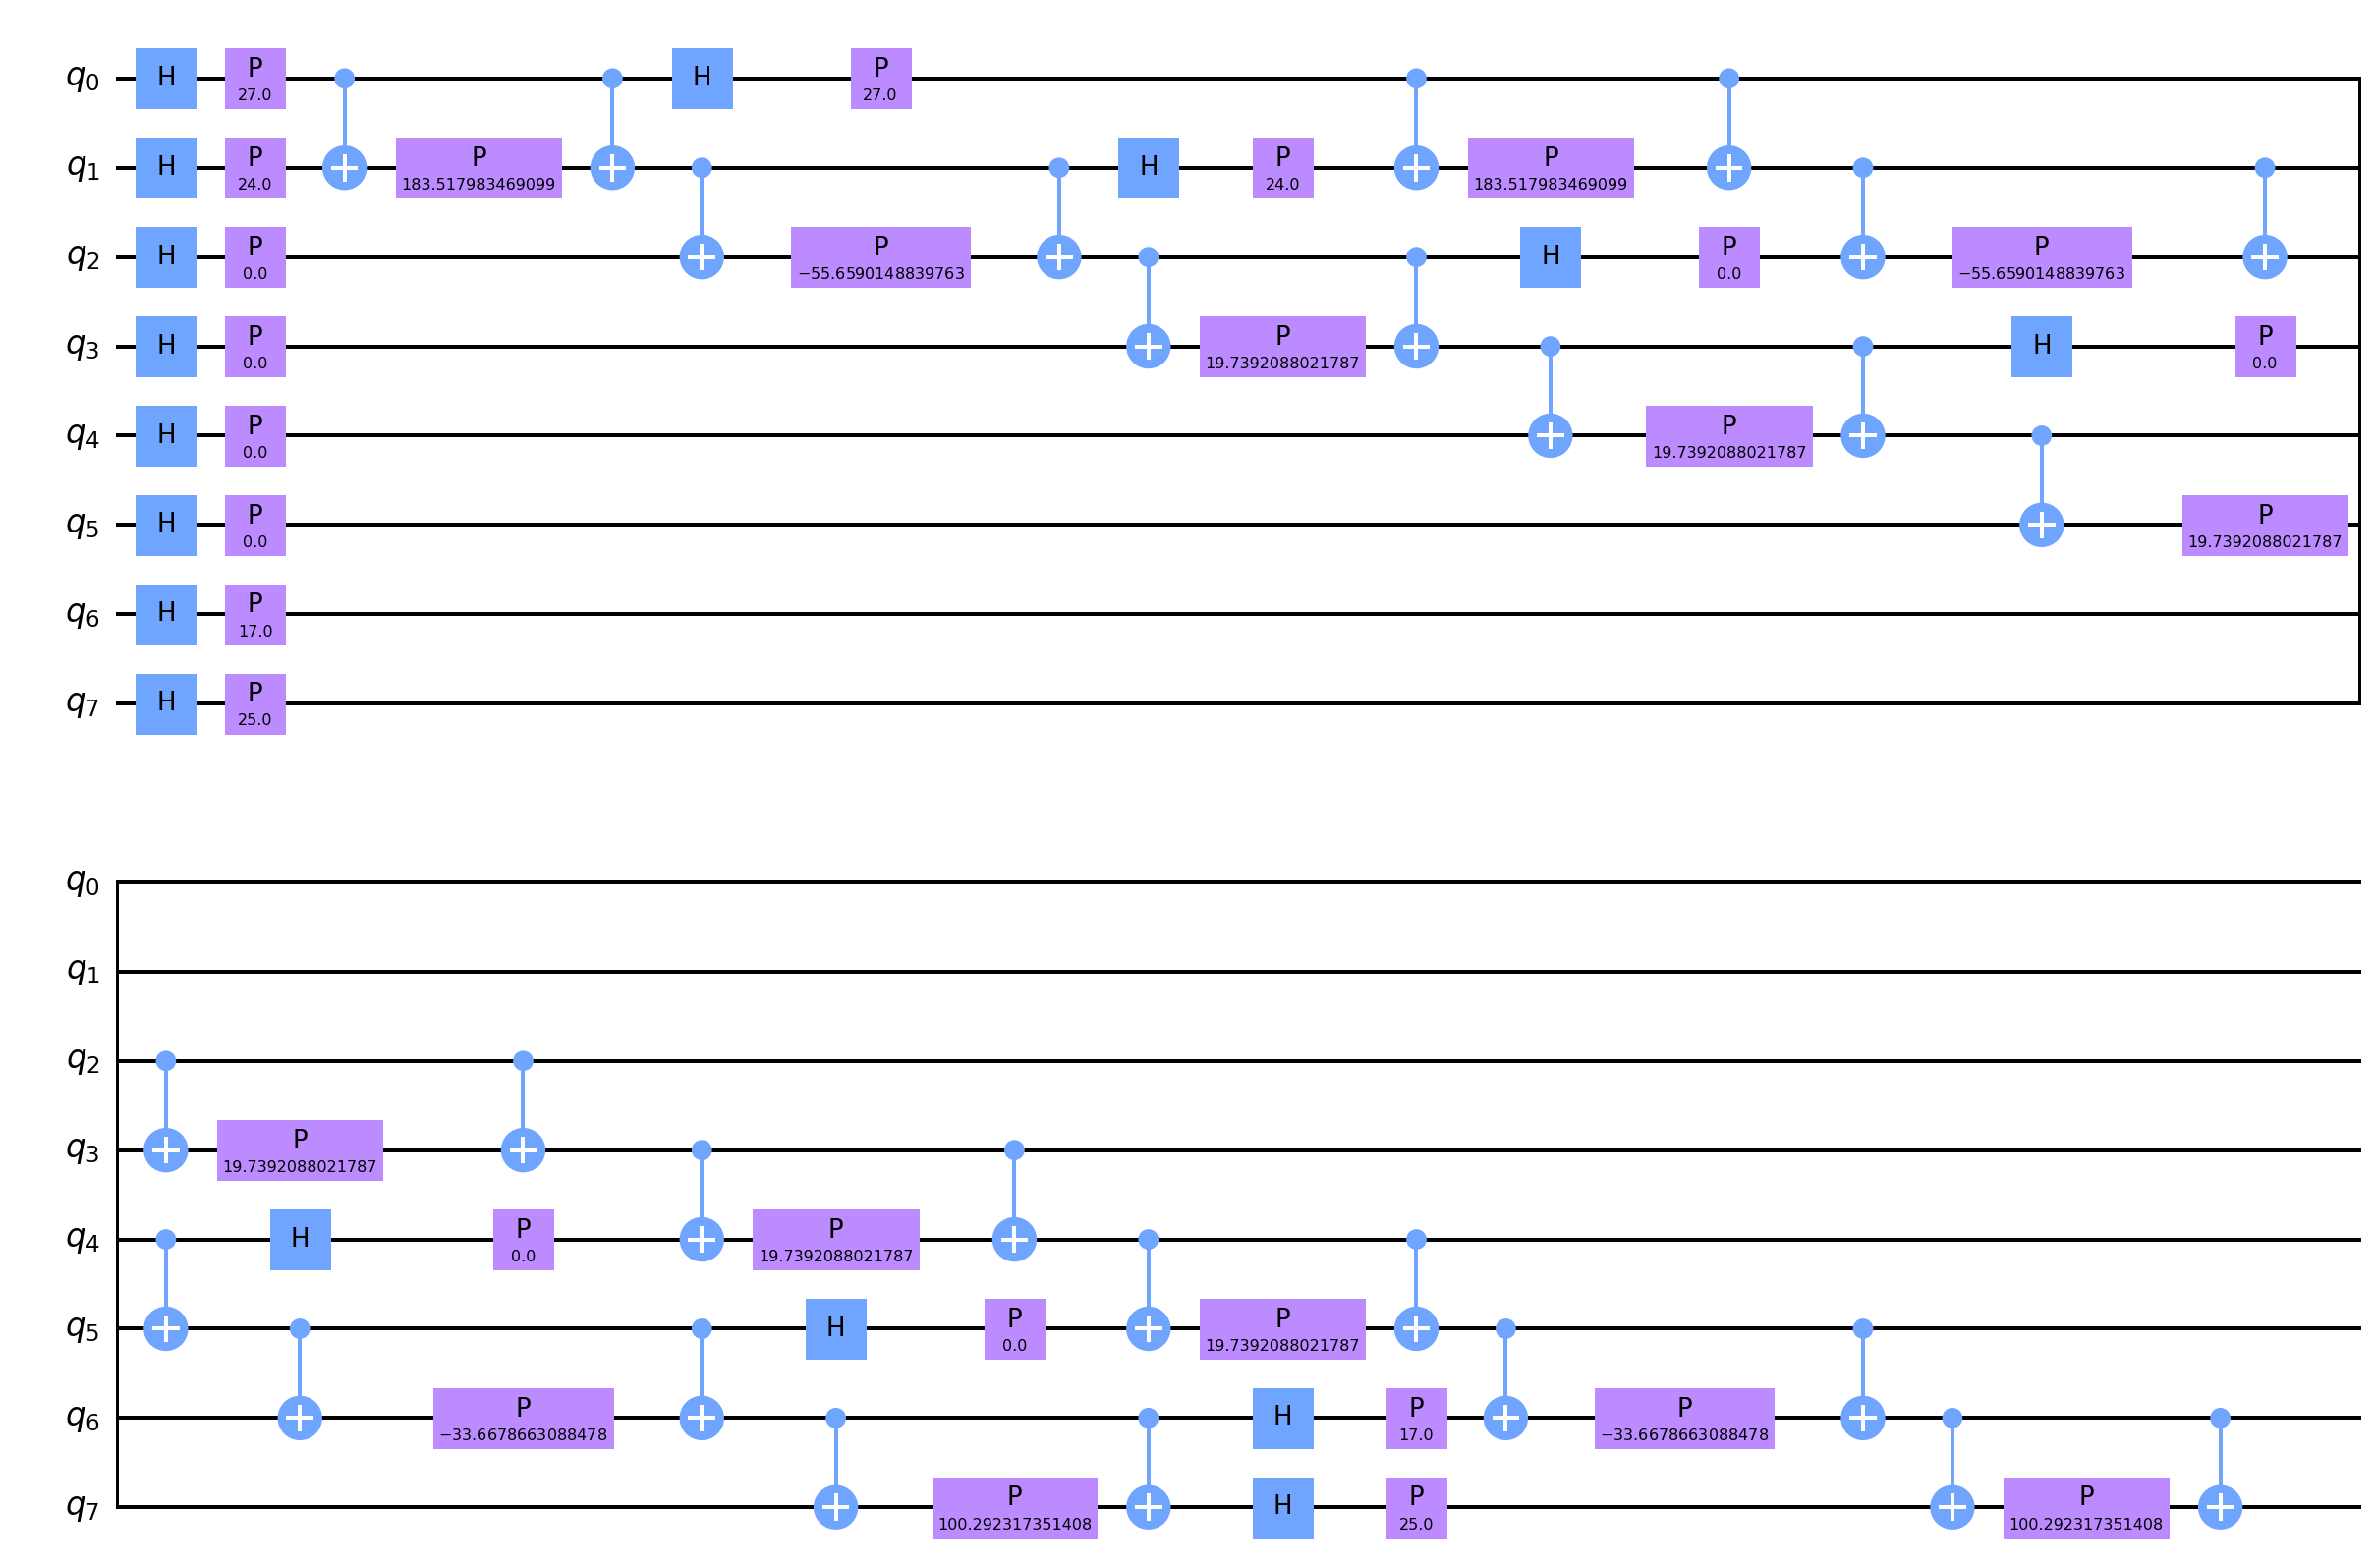

In [9]:
# Reshape input data size from (4,1) to (4,)
x_train_4 = x_train_4x1.reshape(x_train_4x1.shape[:-1])
x_test_4 = x_test_4x1.reshape(x_test_4x1.shape[:-1])

fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x_train_4[0])}).decompose().draw('mpl', scale=2)
#this plugs in values for the parameters in the above circuit.

# Anstaz

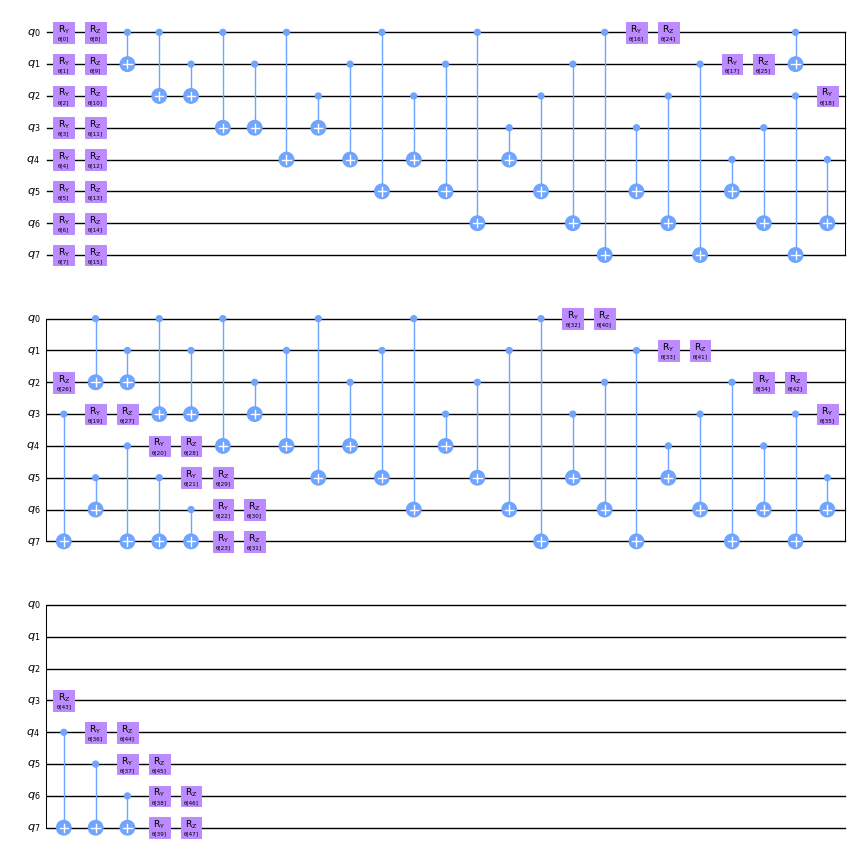

In [10]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(feature_dim, ['ry', 'rz'], 2, 'full')
ansatz_tl.decompose().draw('mpl', scale=0.7)

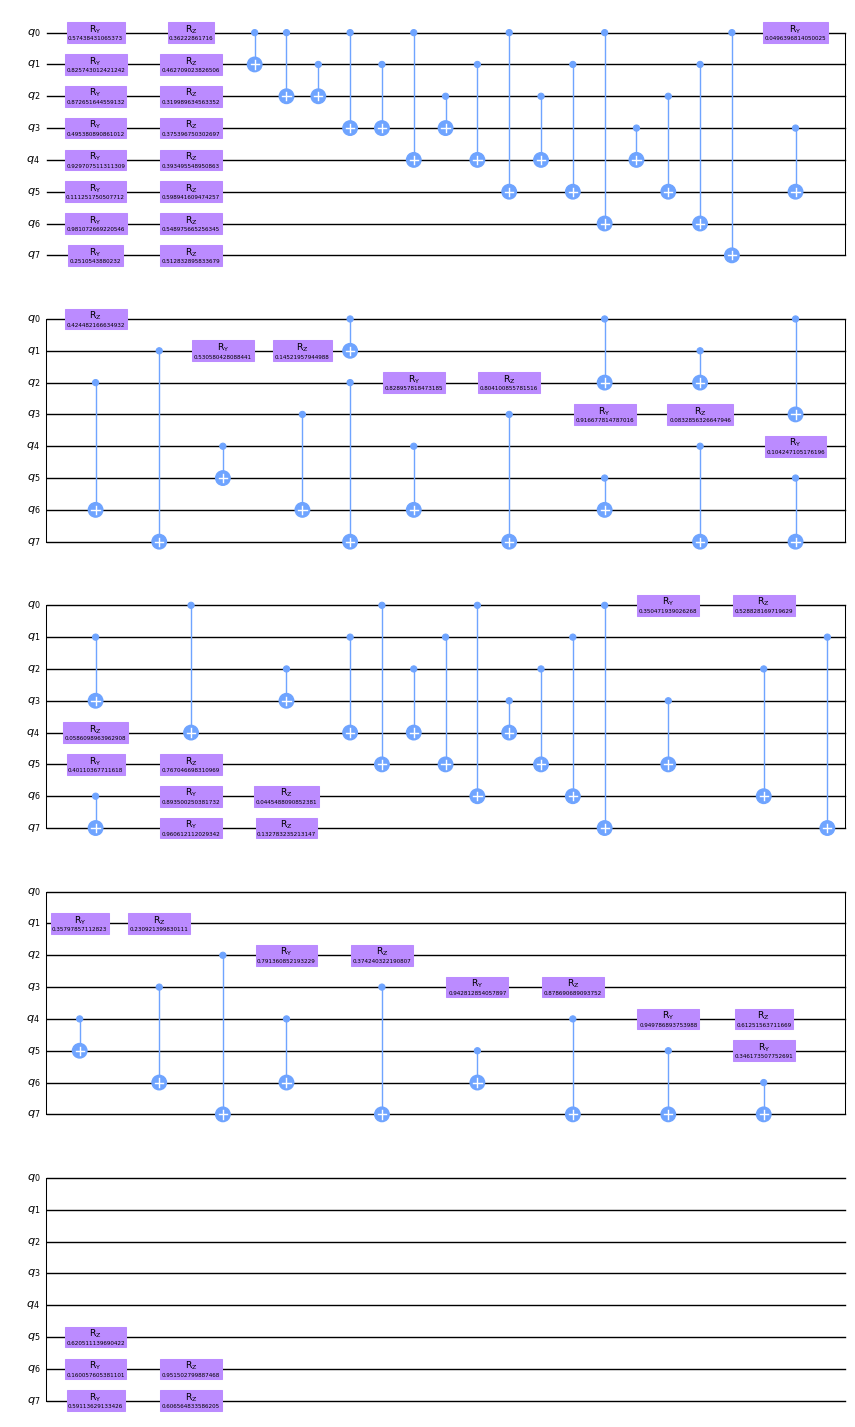

In [11]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)

# Quantum Neural Network

## CircuitQNN

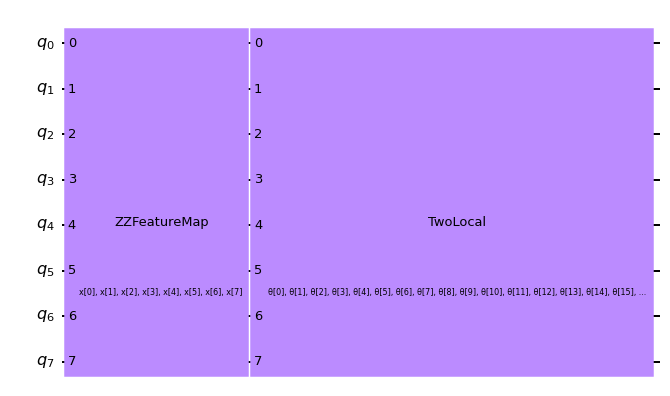

In [12]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw('mpl')
# below we see the data embedding step, followed by the asnatz

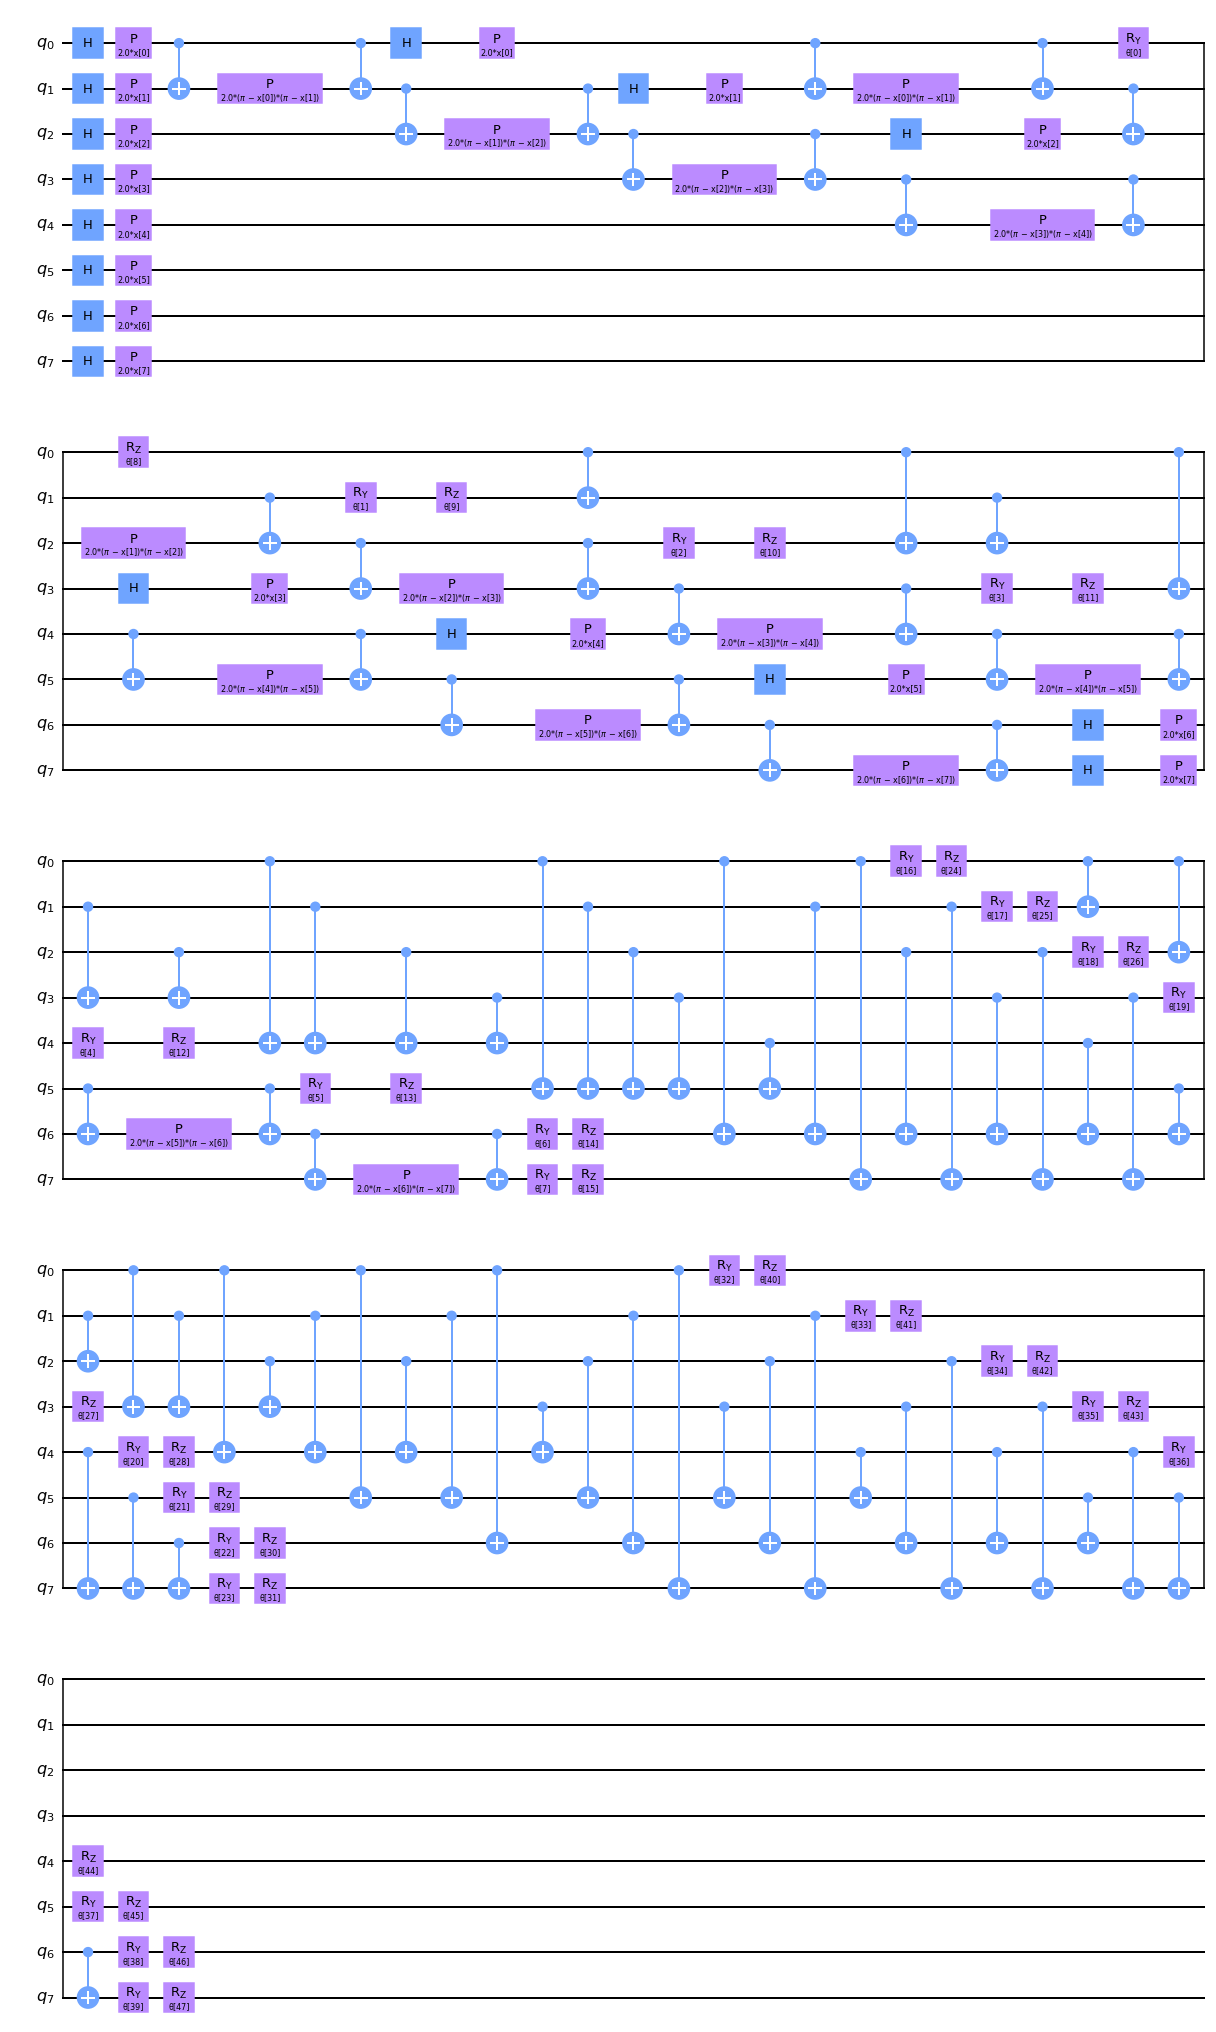

In [13]:
var_circuit.decompose().draw('mpl')

In [14]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [15]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

# this circuit returns measurements.

# data embedding determines input_params
# the asnatz determines the weights of the input params
# 

### Forward pass

In [16]:
# The result of the neural network of the shape (output_shape).
output = qnn.forward(x_train_4[0], weights)
print(output.shape)
output
# based on output being larger, would assume that the data belongs to the second class.

(1, 2)


array([[0.6328125, 0.3671875]])

### Backward pass

In [17]:
# The result of the neural network of the backward pass, i.e., a tuple with the gradients
# for input and weights of shape (output_shape, num_input) and
# (output_shape, num_weights), respectively.
_, update = qnn.backward(x_train_4[0], weights)
update

array([[[ 0.22607422,  0.01025391, -0.00244141, -0.00097656,
         -0.00390625, -0.00268555, -0.0222168 ,  0.0168457 ,
          0.02050781, -0.00390625,  0.00732422,  0.00146484,
          0.00097656, -0.00390625, -0.01245117, -0.00585937,
          0.00390625,  0.01171875,  0.02099609,  0.0090332 ,
          0.0065918 , -0.03320312, -0.0090332 , -0.01000977,
          0.015625  ,  0.02148438,  0.02099609,  0.01855469,
         -0.00512695, -0.00317383,  0.00512695,  0.00170898,
         -0.00756836,  0.00146484, -0.00976562,  0.01000977,
          0.00341797,  0.01025391,  0.00854492,  0.00146484,
          0.00415039, -0.01000977,  0.00415039, -0.00317383,
          0.02099609, -0.01147461,  0.00341797,  0.00439453],
        [-0.22607422, -0.01025391,  0.00244141,  0.00097656,
          0.00390625,  0.00268555,  0.0222168 , -0.0168457 ,
         -0.02050781,  0.00390625, -0.00732422, -0.00146484,
         -0.00097656,  0.00390625,  0.01245117,  0.00585938,
         -0.00390625, -

## OpflowQNN

In [18]:
obs_parity = Z ^ feature_dim
obs_one_qubit = I ^ (feature_dim - 1) ^ Z
obs_one_qubit

PauliOp(Pauli('IIIIIIIZ'), coeff=1.0)

In [19]:
# For an introduction to the Opflow module, see
# https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/operators/01_operator_flow.ipynb
operator = ~StateFn(obs_one_qubit) @ StateFn(var_circuit)
operator

ComposedOp([OperatorStateFn(PauliOp(Pauli('IIIIIIIZ'), coeff=1.0), coeff=1.0, is_measurement=True), CircuitStateFn(<qiskit.circuit.library.data_preparation.zz_feature_map.ZZFeatureMap object at 0x0000016101B776D0>, coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)

In [20]:
gradient = Gradient(grad_method="param_shift")
op_qnn = OpflowQNN(operator,
                   input_params=fmap_zz.parameters,
                   weight_params=ansatz_tl.parameters,
                   gradient=gradient,
                   quantum_instance=qinst)

### Forward pass

In [21]:
output = op_qnn.forward(x_train_4[0], weights)
print(output.shape)
output

#output here is an expectation value

(1, 1)


array([[0.20996094]])

### Backward pass

In [22]:
_, update = op_qnn.backward(x_train_4[0], weights)
print(update.shape)
update

(1, 1, 48)


array([[[ 4.89257812e-01, -3.90625000e-03, -3.41796875e-02,
          1.17187500e-02,  1.61132812e-02, -2.63671875e-02,
         -1.75781250e-02,  2.83203125e-02,  5.46875000e-02,
          2.73437500e-02, -4.88281250e-03,  0.00000000e+00,
          2.92968750e-03, -2.44140625e-03, -3.51562500e-02,
         -8.30078125e-03,  3.12500000e-02, -3.41796875e-02,
         -9.76562500e-04,  1.80664062e-02,  4.39453125e-03,
         -2.92968750e-03, -2.44140625e-03, -2.44140625e-03,
          3.90625000e-02,  1.26953125e-02,  4.00390625e-02,
          1.36718750e-02,  1.85546875e-02,  2.34375000e-02,
         -5.85937500e-03,  2.34375000e-02, -2.49023438e-02,
         -1.31835938e-02,  4.88281250e-03, -2.44140625e-03,
         -5.37109375e-03, -1.41601562e-02,  2.92968750e-03,
          4.88281250e-04,  1.22070312e-02,  1.12304688e-02,
         -1.12304688e-02, -1.17187500e-02, -2.24609375e-02,
         -3.41796875e-02, -6.83593750e-03,  1.36718750e-02]]])

# Train a Neural Network Classifier with CircuitQNN

In [23]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

how one hot encoding works

2 classes: {0,1}

label 0 --> [1,0] #first index is 1 if class is 0, second index is 1 if class is 1, etc.

label 1--> [0,1] 

3 classes: {0,1,2}

label 0 --> [1,0,0]

label 1 --> [0,1,0]

label 2 --> [0,0,1]

In [24]:
print(y_train[1])
print(y_train_1h[1])

1
[0. 1.]


In [25]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [26]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


x_train_4_norm = np.array([x/np.linalg.norm(x) for x in x_train_4])

vqc = vqc.fit(x_train_4_norm, y_train_1h)

3 - 56.993739690329534
6 - 56.49771205997243
9 - 44.35892211156843
12 - 43.278484029917635
15 - 43.47944587602744
18 - 41.70408096628963
21 - 41.45822830238022
24 - 41.368521739839345
27 - 41.129053177641275
30 - 41.57616581116703
33 - 41.48712115068231
36 - 41.007775376663886
39 - 40.556937118533355
42 - 40.60185415809997
45 - 40.46141727402716
48 - 40.59297233908715
51 - 40.786511365822726
54 - 40.61259626159318
57 - 40.243048863318606
60 - 40.68503316890553
63 - 40.381170309375065
66 - 40.52699295361532
69 - 40.591872546694844
72 - 40.63501364281417
75 - 40.349424957872486
78 - 40.19851299731354
81 - 40.700143220843884
84 - 40.411149833001346
87 - 40.45931509209859
90 - 40.472115943008035
93 - 40.456552195689945
96 - 40.529309851657246
99 - 40.810001327586946
102 - 40.43001960300148
105 - 40.09474178525989
108 - 40.57744012877569
111 - 40.41581276376242
114 - 40.624734596670876
117 - 40.359102280573666
120 - 40.33976135115505
123 - 40.35667206148851
126 - 40.97859415387923
129 - 40.

In [27]:
score_train = vqc.score(x_train_4, y_train_1h)
score_test = vqc.score(x_test_4, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.5375
Score on the test set 0.3


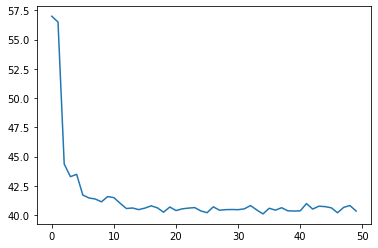

In [28]:
plt.plot(loss_recorder)

# Train a Neural Network Classifier with OpflowQNN and Gradient Descent

In [52]:
y_train_pm = np.array([-1 if y==0 else y for y in y_train])
y_test_pm = np.array([-1 if y==0 else y for y in y_test])
y_train.shape

(80,)

In [53]:
max_itr = 10
gd_opt = GradientDescent(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
op_vqc = NeuralNetworkClassifier(neural_network=op_qnn,
                                 loss=L2Loss(),
                                 one_hot=False,
                                 optimizer=gd_opt,
                                 initial_point=initial_point)

op_vqc = op_vqc.fit(x_train_4, y_train_pm)

1 - 74.69731044769287
2 - 75.58895778656006
3 - 74.08141708374023
4 - 73.79434299468994
5 - 73.58063125610352
6 - 74.04110431671143
7 - 72.82831287384033
8 - 72.46956634521484
9 - 71.66981315612793
10 - 71.62222957611084


In [54]:
score_train = op_vqc.score(x_train_4, y_train_pm)
score_test = op_vqc.score(x_test_4, y_test_pm)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.625
Score on the test set 0.6


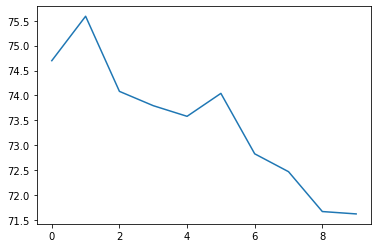

In [55]:
plt.plot(loss_recorder)